Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Цель построить модель со значением метрики качества *F1* не меньше 0.75. 


### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

## 1.1. Загрузим библиотеки 

In [1]:
# Импортируем библиотеки
# для работы с данными
import pandas as pd
import numpy as np

#Предупреждения
import warnings
warnings.filterwarnings('ignore')

#для загрузки данных
from pathlib import Path
import os
import urllib.request

#для графиков
import matplotlib.pyplot as plt
import seaborn as sns

#Для работы с текстом
from pymystem3 import Mystem
import re
from nltk.corpus import stopwords
import nltk
import en_core_web_sm


#для построения моделей
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.utils import shuffle


#бары прогресса
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm.pandas()


In [2]:
import torch
import transformers as ppb # pytorch transformers

In [3]:
nltk.download('stopwords')
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.2. Загрузим данные и произведем предобработку

In [116]:
#Cоздадим папку если ее нет
Path('datasets').mkdir(parents=True, exist_ok=True)

#словарь с именем файла и ссылкой на него
urls = {
    'toxic_comments': ('.../datasets/toxic_comments.csv', '/datasets/toxic_comments.csv'),
}

#Проверим есть ли файл
if not os.path.exists(urls.get(*urls.keys())[1]):
    print(urls.get(*urls.keys())[1], 'файл не найден, будет загружен из сети')
    #качаем файл по ссылке url, кладем по пути file_name
    urllib.request.urlretrieve(*urls.get(*urls.keys()))
     
data =  pd.read_csv(urls.get(*urls.keys())[1])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
data.text = data.text.astype('U')

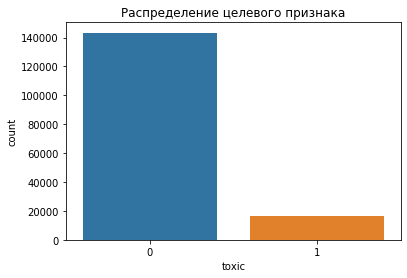

In [8]:
sns.countplot(data.toxic)
plt.title('Распределение целевого признака');

Наблюдается дисбаланс, попробуем upsampling

## 1.3. Подготовим выборки для обучения

Лемматизацию производили при помощи spaCy
по вот такому коду:
```python
nlp = en_core_web_sm.load()

def clearn_and_lemmatize(row, find_this=r"[^a-zA-z-]", replace_for=' '):
    
    try:    
        sentence = row.lower()
        doc = nlp(sentence)
        lemmatized_row = " ".join([token.lemma_ for token in doc])

        clean_row = re.sub(find_this, replace_for, lemmatized_row).split()

        return ' '.join(clean_row)
    
    except RecursionError:
        return 'Error'

data['lemm_text'] = data['text'].apply(clearn_and_lemmatize)
```

Но так как это занимает много времени (в тренажере лемматизация всех позиций занимает ~1 час), а влияния на метрику практически не обнаружено по сравнению с сырыми данными, то выполнять ее не будем

Произведем очистку данных при помощи регулярных выражений

In [9]:
def clean_regular(row, find_this=r"[^a-zA-z-]", replace_for=' '):
    
    row = row.lower()
    clean_row = re.sub(find_this, replace_for, row).split()
    
    return ' '.join(clean_row)

In [117]:
data['clean_text'] = data.text.progress_apply(clean_regular)

100%|██████████| 159571/159571 [00:06<00:00, 23755.06it/s]


Подготовим выботки из сырых данных (raw) и очищенных (cln) и применим величины TF-IDF для наших текстов

In [11]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(data.text, data.toxic, test_size=.2, random_state=42)

tfidf_vectorized_raw = TfidfVectorizer(stop_words=stop_words)

tfidf_vectorized_raw.fit(X_train_raw)
X_test_raw = tfidf_vectorized_raw.transform(X_test_raw)

In [12]:
X_train_cln, X_test_cln, y_train, y_test = train_test_split(data.clean_text,
                                                            data.toxic, test_size=.2, random_state=42)

tfidf_vectorized_cln = TfidfVectorizer(stop_words=stop_words)

tfidf_vectorized_cln.fit(X_train_cln)
X_test_cln = tfidf_vectorized_cln.transform(X_test_cln)

In [13]:
print('Размерность выборок RAW:')
for sample in (X_train_raw, X_test_raw, y_train, y_test):
    
    print('{}'.format(sample.shape))    

Размерность выборок RAW:
(127656,)
(31915, 165640)
(127656,)
(31915,)


In [14]:
print('Размерность выборок Clean:')
for sample in (X_train_cln, X_test_cln, y_train, y_test):
    
    print('{}'.format(sample.shape)) 

Размерность выборок Clean:
(127656,)
(31915, 151383)
(127656,)
(31915,)


# 2. Обучение

In [15]:
results = {
    'model_name' : [],
    'vectorized_type' : [],
    'f1_score' : [],
    'train_sample_shape' : [],
    'text_type' : [],
    'tuning' : []
}

In [16]:
def add_to_result_table(model_name, res_dict, vectorized_type, f1_score, train_sample_shape, text_type, tuning):
    res_dict["model_name"].append(model_name)
    res_dict["vectorized_type"].append(vectorized_type)
    res_dict["f1_score"].append(f1_score)
    res_dict["train_sample_shape"].append(train_sample_shape)
    res_dict["text_type"].append(text_type)
    res_dict["tuning"].append(tuning)
    
    
    df = pd.DataFrame(res_dict)
   
    return df, res_dict

## 2.1. LogisticRegression

In [17]:
def plot_confusion_matrix(model, X_test, y_test):
    
    prediction = model.predict(X_test)
    print('Accuracy : {:.4f}'.format(accuracy_score(y_test, prediction)))
    print('F1 метрика: {:.4f}'.format(f1_score(y_test, prediction)))
    
    sanity_check = pd.Series([0 for i in range(len(y_test))])
    print('Sanity check accuracy: {:.4f}'.format(accuracy_score(y_test, sanity_check)))
    
    sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', linewidths=.8)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

### 2.1.1 Сырые данные

In [18]:
model_lr_raw = LogisticRegression(random_state=42)

X_train_raw_vect = tfidf_vectorized_raw.transform(X_train_raw)

model_lr_raw.fit(X_train_raw_vect, y_train)

predict_lr_raw = model_lr_raw.predict(X_test_raw)
f1_lr_raw = f1_score(y_test, predict_lr_raw)

Accuracy : 0.9557
F1 метрика: 0.7355
Sanity check accuracy: 0.8984


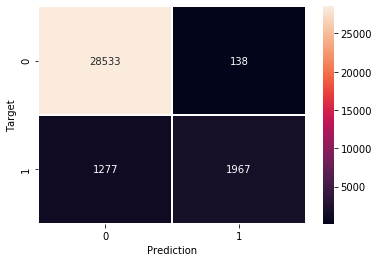

In [19]:
plot_confusion_matrix(model_lr_raw, X_test_raw, y_test)

In [20]:
df_result, results = add_to_result_table('LogisticRegression', results, 'TF-IDF',
                                        round(f1_lr_raw, 5), X_train_raw_vect.shape, 'raw', 'default'
                                       )

### 2.1.2 Текст очищен при помощи регулярных выражений

In [21]:
model_lr_cln = LogisticRegression(random_state=42)

X_train_cln_vect = tfidf_vectorized_cln.transform(X_train_cln)

model_lr_cln.fit(X_train_cln_vect, y_train)

predict_lr_cln = model_lr_cln.predict(X_test_cln)
f1_lr_cln = f1_score(y_test, predict_lr_cln)

Accuracy : 0.9559
F1 метрика: 0.7382
Sanity check accuracy: 0.8984


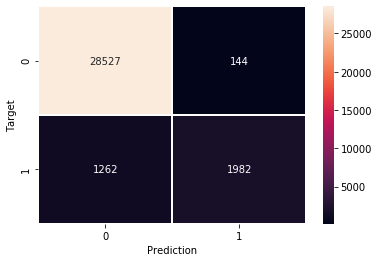

In [22]:
plot_confusion_matrix(model_lr_cln, X_test_cln, y_test)

In [23]:
df_result, results = add_to_result_table('LogisticRegression', results, 'TF-IDF',
                                        round(f1_lr_cln, 5), X_train_cln_vect.shape, 'clean', 'default'
                                       )

### 2.1.3 Сырые данные с настройкой порога

In [24]:
def trheshold_tune(model, X_test, y_test, range_for_treshhold=np.arange(0.2, 0.8, 0.001), figsize=(15, 5)):
    
    f1_values = []
    f1_max = 0
    best_tresh_hold = 0
    
    probabilities = model.predict_proba(X_test)
    
    for threshold in tqdm_notebook(range_for_treshhold):
        predicted = probabilities[:, 1] > threshold
        f1 = f1_score(y_test, predicted)
        f1_values.append(f1)
        if f1 > f1_max:
            f1_max = f1
            best_tresh_hold = threshold
    
    df = pd.DataFrame(f1_values, index=range_for_treshhold)
    
    with plt.style.context('bmh'):    
        plt.figure(figsize=figsize)
        plt.plot(df)
        plt.ylabel('f1 score')
        plt.xlabel('Порог')
        plt.title('Значение f1_score при соответствующем пороге \
                  \nЛучший результат:\nПорог: {:0.3f};  f1_score: {:0.5f}.'.format(best_tresh_hold, f1_max))
        plt.show()


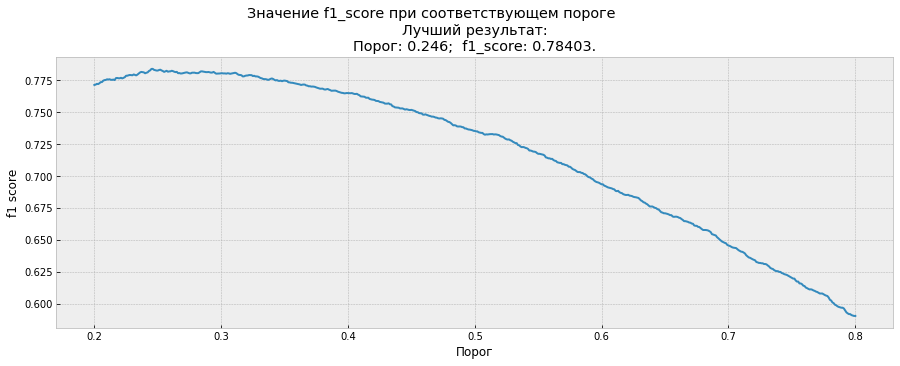

In [25]:
trheshold_tune(model_lr_raw, X_test_raw, y_test)

In [26]:
def predict_using_trehold(model, X_test, y_test, treshold=0.5):
    
    probabilities = model.predict_proba(X_test)
    prediction = (probabilities[:, 1] > treshold) * 1
    print('F1 метрика: {:.4f}'.format(f1_score(y_test, prediction)))
    
    sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', linewidths=.8)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()
    
    return prediction

F1 метрика: 0.7840


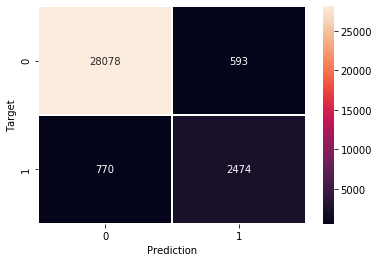

In [27]:
predict_lr_raw_tresh_tune = predict_using_trehold(model_lr_raw, X_test_raw, y_test, treshold=0.246)

In [28]:
f1_lr_raw_tresh_tune = f1_score(y_test, predict_lr_raw_tresh_tune)

In [29]:
df_result, results = add_to_result_table('LogisticRegression', results, 'TF-IDF',
                                        round(f1_lr_raw_tresh_tune, 5), X_train_raw_vect.shape, 'raw', 'treshold tuned'
                                       )

### 2.1.4 Очищенные данные с настройкой порога

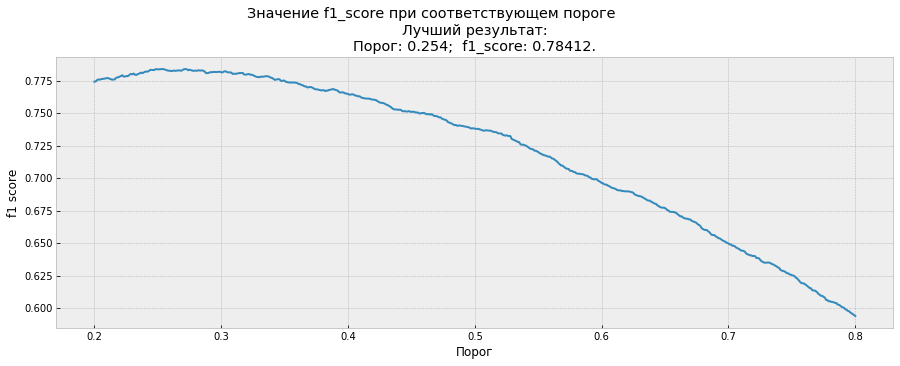

In [30]:
trheshold_tune(model_lr_cln, X_test_cln, y_test)

F1 метрика: 0.7841


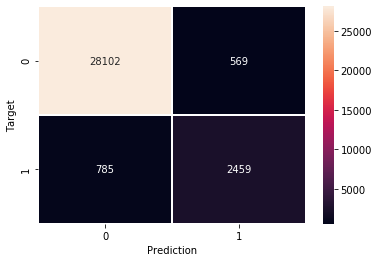

In [31]:
predict_lr_cln_tresh_tune = predict_using_trehold(model_lr_cln, X_test_cln, y_test, treshold=0.254)

In [32]:
f1_lr_cln_tresh_tune = f1_score(y_test, predict_lr_cln_tresh_tune)

In [33]:
df_result, results = add_to_result_table('LogisticRegression', results, 'TF-IDF',
                                        round(f1_lr_cln_tresh_tune, 5), X_train_cln_vect.shape, 
                                        'clean', 'treshold tuned'
                                       )

### 2.1.5 Сырые данные с upsampling

In [34]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [35]:
def upsample_tune(model, tfidf_vectorized, X_train, y_train, X_test, y_test,  repeat_from=1, repeat_to=8):
        
    model_upsamp_score = {
            "repeat_number" : 0,
            "f1_score" : 0
        }
    f1_for_plot = []
    for repeat_number in tqdm_notebook(range(repeat_from, repeat_to)):
        X_upsampled, y_upsampled = upsample(X_train, y_train, repeat_number)
        X_ups_vect = tfidf_vectorized.transform(X_upsampled) 

        model.fit(X_ups_vect, y_upsampled)
        predict = model.predict(X_test)
        f1 = f1_score(y_test, predict)
        f1_for_plot.append(f1)
        if f1 > model_upsamp_score['f1_score']:
            model_upsamp_score['f1_score'] = f1
            model_upsamp_score['repeat_number'] = repeat_number
            best_model = model

    with plt.style.context('bmh'):    
        plt.figure(figsize=(15, 5))
        plt.step(range(repeat_from, repeat_to), f1_for_plot, where='post')
        plt.ylabel('f1 score')
        plt.xlabel('Количество повторений класса "1"')
        plt.title('Значение f1_score при количестве повторений')
        plt.show()
        print('Лучший результат f1 = {:.4f}'.format(model_upsamp_score['f1_score']))
        print('При количестве повторений: {}'.format(model_upsamp_score['repeat_number']))


In [36]:
model_lr_raw_upsmpl = LogisticRegression(random_state=42)

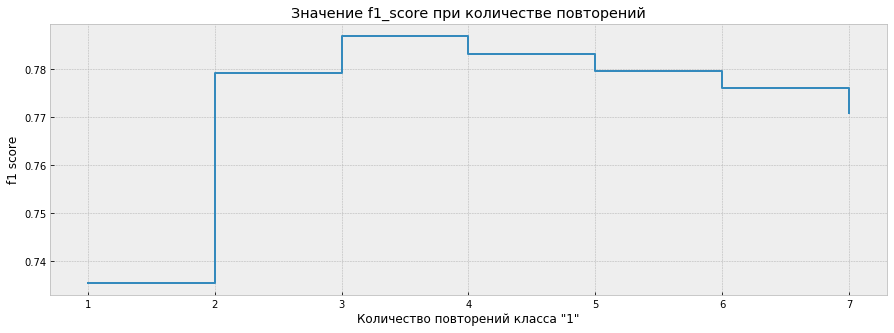

Лучший результат f1 = 0.7869
При количестве повторений: 3


In [37]:
upsample_tune(model_lr_raw_upsmpl, tfidf_vectorized_raw, X_train_raw, y_train, X_test_raw, y_test)

In [38]:
X_raw_ups_train, y_raw_ups_train = upsample(X_train_raw, y_train, 3)
X_raw_ups_train = tfidf_vectorized_raw.transform(X_raw_ups_train)

In [39]:
model_lr_raw_upsmpl = LogisticRegression(random_state=42)

model_lr_raw_upsmpl.fit(X_raw_ups_train, y_raw_ups_train)

predict_lr_raw_upsmpl = model_lr_raw_upsmpl.predict(X_test_raw)
f1_lr_raw_upsmpl = f1_score(y_test, predict_lr_raw_upsmpl)

Accuracy : 0.9587
F1 метрика: 0.7869
Sanity check accuracy: 0.8984


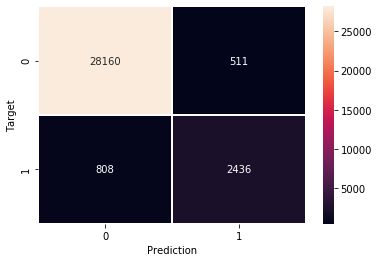

In [40]:
plot_confusion_matrix(model_lr_raw_upsmpl, X_test_raw, y_test)

In [41]:
df_result, results = add_to_result_table('LogisticRegression', results, 'TF-IDF',
                                        round(f1_lr_raw_upsmpl, 5), X_raw_ups_train.shape, 
                                        'raw', 'upsampling'
                                       )

### 2.1.6 Очищенные данные с upsampling

In [42]:
model_lr_cln_upsmpl = LogisticRegression(random_state=42)

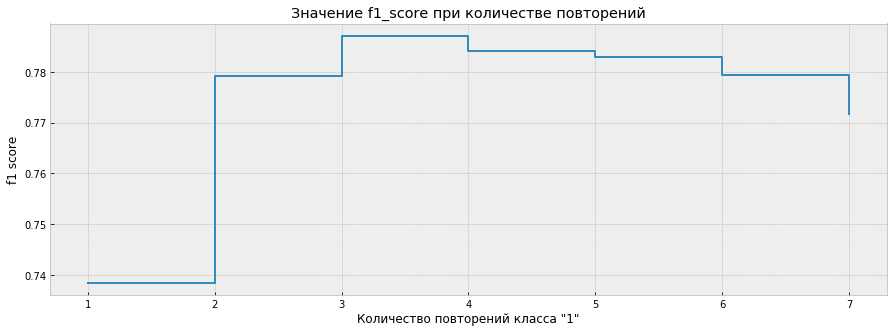

Лучший результат f1 = 0.7871
При количестве повторений: 3


In [43]:
upsample_tune(model_lr_cln_upsmpl, tfidf_vectorized_cln, X_train_cln, y_train, X_test_cln, y_test)

In [44]:
X_cln_ups_train, y_cln_ups_train = upsample(X_train_cln, y_train, 3)
X_cln_ups_train = tfidf_vectorized_cln.transform(X_cln_ups_train)

In [45]:
model_lr_cln_upsmpl = LogisticRegression(random_state=42)

model_lr_cln_upsmpl.fit(X_cln_ups_train, y_cln_ups_train)

predict_lr_cln_upsmpl = model_lr_cln_upsmpl.predict(X_test_cln)
f1_lr_cln_upsmpl = f1_score(y_test, predict_lr_cln_upsmpl)

Accuracy : 0.9586
F1 метрика: 0.7871
Sanity check accuracy: 0.8984


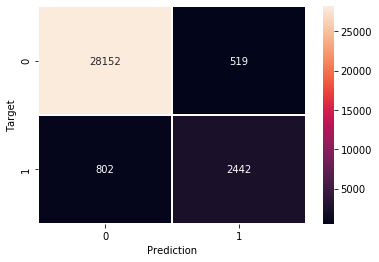

In [46]:
plot_confusion_matrix(model_lr_cln_upsmpl, X_test_cln, y_test)

In [47]:
df_result, results = add_to_result_table('LogisticRegression', results, 'TF-IDF',
                                        round(f1_lr_cln_upsmpl, 5), X_cln_ups_train.shape, 
                                        'clean', 'upsampling'
                                       )

### 2.1.7 Сырые данные с настройкой порога и upsampling

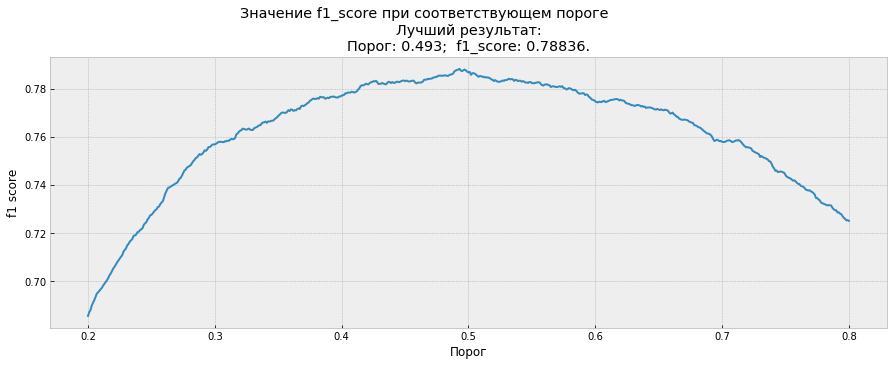

In [48]:
trheshold_tune(model_lr_raw_upsmpl, X_test_raw, y_test)

F1 метрика: 0.7884


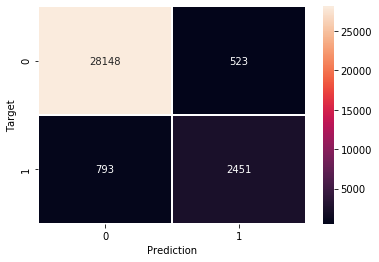

In [49]:
predict_lr_raw_upsmpl_tresh_tune = predict_using_trehold(model_lr_raw_upsmpl, X_test_raw, y_test, treshold=0.493)

In [50]:
f1_lr_raw_upsmpl_tresh_tune = f1_score(y_test, predict_lr_raw_upsmpl_tresh_tune)

In [51]:
df_result, results = add_to_result_table('LogisticRegression', results, 'TF-IDF',
                                        round(f1_lr_raw_upsmpl_tresh_tune, 5), X_raw_ups_train.shape, 
                                        'clean', 'treshold tuned and upsampling'
                                       )

### 2.1.8 Очищенные данные с настройкой порога и upsampling

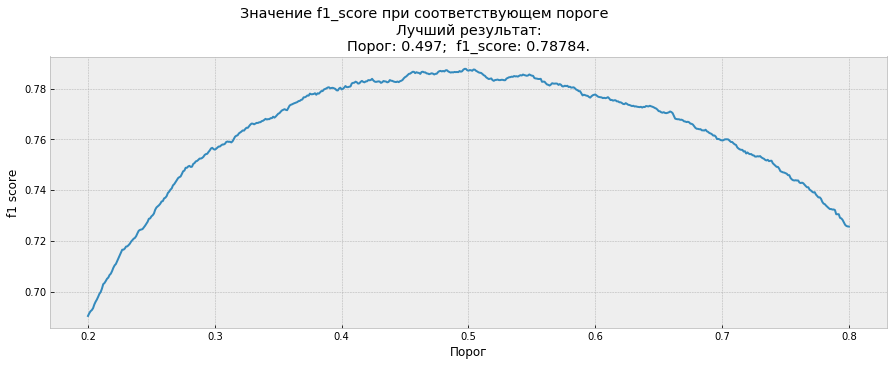

In [52]:
trheshold_tune(model_lr_cln_upsmpl, X_test_cln, y_test)

F1 метрика: 0.7878


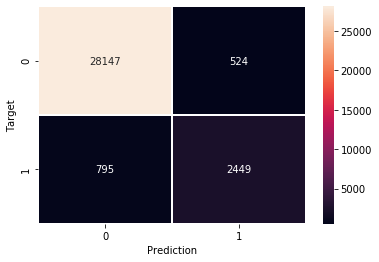

In [53]:
predict_lr_cln_upsmpl_tresh_tune = predict_using_trehold(model_lr_cln_upsmpl, X_test_cln, y_test, treshold=0.497)

In [54]:
f1_lr_cln_upsmpl_tresh_tune = f1_score(y_test, predict_lr_cln_upsmpl_tresh_tune)

In [55]:
df_result, results = add_to_result_table('LogisticRegression', results, 'TF-IDF',
                                        round(f1_lr_cln_upsmpl_tresh_tune, 5), X_cln_ups_train.shape, 
                                        'clean', 'treshold tuned and upsampling'
                                       )

### 2.1.9 Сырые данные GridSearch

In [56]:
%%time
parameters = {'C': np.linspace(0.001, 50, 10)}
grid_search = GridSearchCV(LogisticRegression(), parameters, scoring='f1')
grid_search.fit(X_train_raw_vect, y_train)


print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 16.667333333333335}
best scrores:  0.7578820330474622
CPU times: user 4min 36s, sys: 3min 32s, total: 8min 9s
Wall time: 8min 9s


In [57]:
grid_search.score

<bound method BaseSearchCV.score of GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 5.55644444e+00, 1.11118889e+01, 1.66673333e+01,
       2.22227778e+01, 2.77782222e+01, 3.33336667e+01, 3.88891111e+01,
       4.44445556e+01, 5.00000000e+01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
            

Accuracy : 0.9604
F1 метрика: 0.7839
Sanity check accuracy: 0.8984


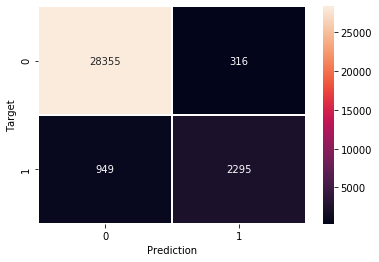

In [58]:
plot_confusion_matrix(grid_search.best_estimator_, X_test_raw, y_test)

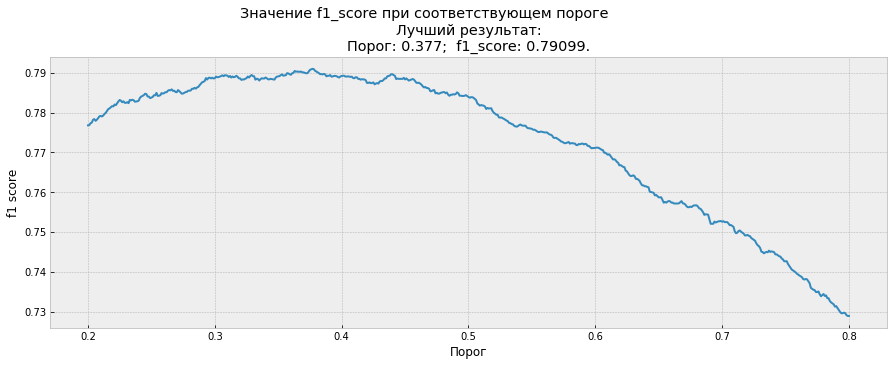

In [59]:
trheshold_tune(grid_search.best_estimator_, X_test_raw, y_test)

F1 метрика: 0.7910


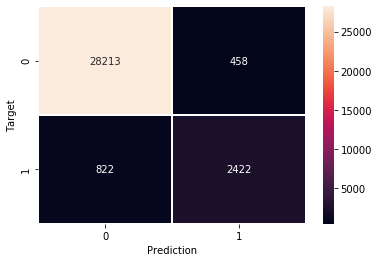

In [60]:
predict_lr_raw_grdsch_tresh_tune = predict_using_trehold(grid_search.best_estimator_, 
                                                         X_test_raw, y_test, treshold=0.377)

In [61]:
f1_lr_raw_grdsch_tresh_tune = f1_score(predict_lr_raw_grdsch_tresh_tune, y_test)

In [62]:
df_result, results = add_to_result_table('LogisticRegression', results, 'TF-IDF',
                                        round(f1_lr_raw_grdsch_tresh_tune, 5), X_train_raw_vect.shape, 
                                        'raw', 'treshold tuned and Gridrsaearch'
                                       )

## 2.2. DistilBERT

In [64]:
model_disBERT, tokenizer_disBERT, pretrained_weights = (ppb.DistilBertModel, 
                                                    ppb.DistilBertTokenizer, 
                                                    'distilbert-base-uncased')

In [65]:
_ = []
for i in range(data.shape[0]):
    if len(data['clean_text'].iloc[i].split()) > 512:
        _.append(i)

In [66]:
data_for_dBERT = data.copy()

In [67]:
data_for_dBERT.drop(index=_, inplace=True)

In [68]:
# Загрузка предобученной модели/токенизатора 
tokenizer_dBERT = tokenizer_disBERT.from_pretrained(pretrained_weights)
model_dBERT = model_disBERT.from_pretrained(pretrained_weights)

In [69]:
X_dBERT, _, y_dBERT, _ = train_test_split(data.clean_text, data.toxic,  
                                          train_size = 500 / data.shape[0], random_state=42)

In [70]:
tokenized_dBERT = X_dBERT.progress_apply(lambda x: tokenizer_dBERT.encode(x, add_special_tokens=True))

 20%|█▉        | 98/500 [00:00<00:00, 432.31it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors
 62%|██████▏   | 312/500 [00:00<00:00, 408.07it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (834 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors
100%|██████████| 500/500 [00:01<00:00, 424.41it/s]


In [71]:
_ = []
for i in range(tokenized_dBERT.shape[0]):
    if len(tokenized_dBERT.iloc[i]) > 512:
        _.append(i)

too_long_text_for_dBERT_index = tokenized_dBERT.iloc[_].index

y_dBERT.drop(index=too_long_text_for_dBERT_index, inplace=True)

tokenized_dBERT.drop(index=too_long_text_for_dBERT_index, inplace=True)

In [72]:
max_len = 0
for i in tokenized_dBERT.values:
    if len(i) > max_len:
        max_len = len(i)

padded_dBERT = np.array([i + [0]*(max_len - len(i)) for i in tokenized_dBERT.values])

In [83]:
padded_dBERT.shape

(493, 509)

In [73]:
attention_mask_dBERT = np.where(padded_dBERT != 0, 1, 0)
attention_mask_dBERT.shape

(493, 509)

In [74]:
batch_size = 50
embeddings_dBERT = []

for i in tqdm_notebook(range(padded_dBERT.shape[0] // batch_size)):
        batch = torch.LongTensor(padded_dBERT[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask_dBERT[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model_dBERT(batch, attention_mask=attention_mask_batch)
        
        embeddings_dBERT.append(batch_embeddings[0][:,0,:].numpy())

In [75]:
features = np.concatenate(embeddings_dBERT)
X_dBERT = pd.DataFrame(features)

y_dBERT = y_dBERT[ : X_dBERT.shape[0]]

X_train_dBERT, X_test_dBERT, y_train_dBERT, y_test_dBERT = train_test_split(X_dBERT, 
                                                                            y_dBERT, 
                                                                            test_size=.5,
                                                                            random_state = 42
                                                                           )

In [76]:
model_lr_dBERT = LogisticRegression()
model_lr_dBERT.fit(X_train_dBERT, y_train_dBERT)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy : 0.9244
F1 метрика: 0.5405
Sanity check accuracy: 0.8978


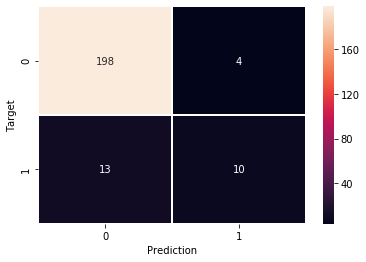

In [77]:
plot_confusion_matrix(model_lr_dBERT, X_test_dBERT, y_test_dBERT)

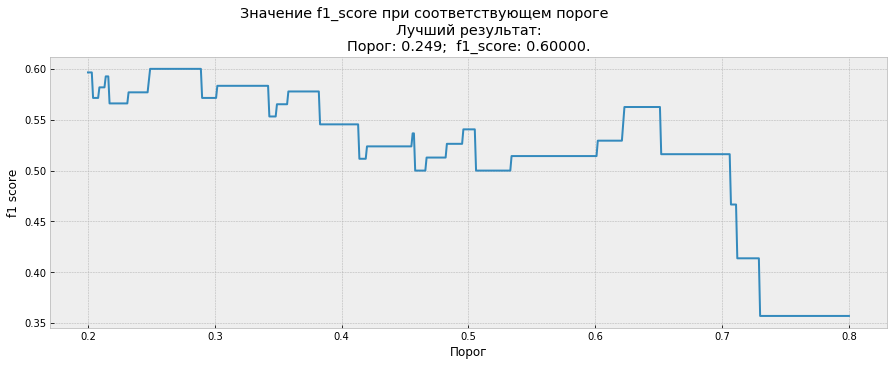

In [78]:
trheshold_tune(model_lr_dBERT, X_test_dBERT, y_test_dBERT)

F1 метрика: 0.6000


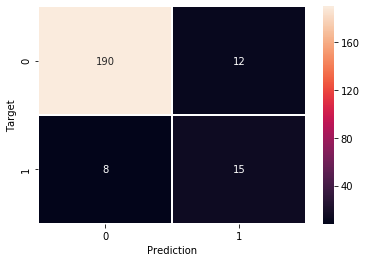

In [79]:
predict_dBERT = predict_using_trehold(model_lr_dBERT, X_test_dBERT, y_test_dBERT, treshold=0.249)

In [80]:
f1_dBERT = f1_score(predict_dBERT, y_test_dBERT)

In [81]:
df_result, results = add_to_result_table('DistilBERT + LogisticRegression', results, 'BERT',
                                        round(f1_dBERT, 5), X_train_dBERT.shape, 
                                        'raw', 'treshold tuned'
                                       )

Модели обучены

# 3. Выводы

In [221]:
df_result.sort_values(by='f1_score', ascending=False)

,model_name,vectorized_type,f1_score,train_sample_shape,text_type,tuning
8,LogisticRegression,TF-IDF,0.79099,"(127656, 165640)",raw,treshold tuned and Gridrsaearch
6,LogisticRegression,TF-IDF,0.78836,"(153618, 165640)",clean,treshold tuned and upsampling
7,LogisticRegression,TF-IDF,0.78784,"(153618, 151383)",clean,treshold tuned and upsampling
5,LogisticRegression,TF-IDF,0.78711,"(153618, 151383)",clean,upsampling
4,LogisticRegression,TF-IDF,0.78695,"(153618, 165640)",raw,upsampling
3,LogisticRegression,TF-IDF,0.78412,"(127656, 151383)",clean,treshold tuned
2,LogisticRegression,TF-IDF,0.78403,"(127656, 165640)",raw,treshold tuned
1,LogisticRegression,TF-IDF,0.73818,"(127656, 151383)",clean,default
0,LogisticRegression,TF-IDF,0.73546,"(127656, 165640)",raw,default
9,DistilBERT + LogisticRegression,BERT,0.60000,"(225, 768)",raw,treshold tuned


1) Логистическая регрессия с применением TF-IDF векторизации дает не плохой результат, при этом нам удалось повысить качество модели с показателя F1-меры равной 0.73 до 0.79 путем подбора порога и параметров для логистической регрессии
2) Модель BERT показывает неплохие результаты даже на небольшой выборке, при увеличении выборки качество модели значительно растет, однако модель ресурсоемкая, удалось получить наилучший результат 0,73 при количестве элементов в выборке ~8000 объектов